# Labeled Convolutional CVAE

In [1]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
# Load pallets library from project root
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))

from pallets import (
    images as I,
    datasets as DS,
    models as M,
    logging as L
)

# Settings

In [3]:
SAVE_NAME = 'cvae.labeledconv'

In [4]:
USE_GPU = True
LOG_LEVEL = 'INFO'
LABELS_FILE = 'pallets_labels.json'

TEST_SIZE = 1000
EPOCHS = 100
LR = 3e-04
BATCH_SIZE = 32


In [5]:
# To GPU, or not to GPU
device = M.get_device(require_gpu=USE_GPU)

# Logging
L.init_logger(level=LOG_LEVEL, notebook=True)


<Logger pallets (INFO)>

# Dataset

In [6]:
all_colors = I.get_punk_colors()
mapper = DS.ColorOneHotMapper(all_colors)
dataset = DS.OneHotCPunksDataset(
    mapper, labels_file=LABELS_FILE, test_size=TEST_SIZE
)

# Uncomment to put entire dataset in GPU RAM
# dataset = DS.FastOneHotCPunksDataset(
#     device, mapper, labels_file=LABELS_FILE, test_size=TEST_SIZE
# )

INFO | loading punk images
INFO | - image 0
INFO | - image 1000
INFO | - image 2000
INFO | - image 3000
INFO | - image 4000
INFO | - image 5000
INFO | - image 6000
INFO | - image 7000
INFO | - image 8000
INFO | - image 9000
INFO | punk images complete
INFO | loading punk labels: pallets_labels.json


In [7]:
train_sampler = SubsetRandomSampler(dataset.train_idx)
test_sampler = SubsetRandomSampler(dataset.test_idx)

train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
test_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=test_sampler)

# Training

In [8]:
input_dim = 222
latent_dim = 32
classes_dim = len(dataset._label_keys)  # 92

In [9]:
model = M.cvae.LabeledConvCVAE(input_dim, latent_dim, classes_dim)
criterion = M.cvae.Loss()

train_losses, test_losses = M.cvae.train(
    device, model, criterion, train_loader, test_loader,
    learn_rate=LR, epochs=EPOCHS, conditional_loss=True
)

M.save(SAVE_NAME, model, train_losses, test_losses)

INFO | model: pallets.models.cvae.LabeledConvCVAE
INFO | criterion: pallets.models.cvae.Loss
INFO | learn rate: 0.0003
INFO | epochs: 100
INFO | epoch 1 (  0%) loss: 2004287.875000
INFO | epoch 1 ( 35%) loss: 341296.053682
INFO | epoch 1 ( 70%) loss: 243350.869248
INFO | epoch 1 (100%) loss: 213741.704704


INFO | epoch 1 (test) loss: 133000.371704
INFO | epoch 2 (  0%) loss: 138496.281250
INFO | epoch 2 ( 35%) loss: 136207.835396
INFO | epoch 2 ( 70%) loss: 135232.631297
INFO | epoch 2 (100%) loss: 134489.173343
INFO | epoch 2 (test) loss: 128455.680786
INFO | epoch 3 (  0%) loss: 135958.031250
INFO | epoch 3 ( 35%) loss: 126584.844833
INFO | epoch 3 ( 70%) loss: 119351.176695
INFO | epoch 3 (100%) loss: 116366.099596
INFO | epoch 3 (test) loss: 105924.974915
INFO | epoch 4 (  0%) loss: 103909.234375
INFO | epoch 4 ( 35%) loss: 108435.931467
INFO | epoch 4 ( 70%) loss: 107630.513759
INFO | epoch 4 (100%) loss: 106900.654844
INFO | epoch 4 (test) loss: 102016.034241
INFO | epoch 5 (  0%) loss: 103616.000000
INFO | epoch 5 ( 35%) loss: 104717.695854
INFO | epoch 5 ( 70%) loss: 103996.600552
INFO | epoch 5 (100%) loss: 102801.422955
INFO | epoch 5 (test) loss: 96950.574219
INFO | epoch 6 (  0%) loss: 98531.296875
INFO | epoch 6 ( 35%) loss: 98498.533957
INFO | epoch 6 ( 70%) loss: 96499.810

# Results

## Random Inputs w/ Real Labels

In [10]:
import random

def rand_label():
    label_idx = int(random.random() * len(dataset._labels))
    features = dataset._labels[label_idx]
    enabled_names = [k for k,v in zip(dataset._label_keys, features) if v.item() == 1]
    return features.to(device), enabled_names


In [11]:
# Generate new image

def rand_punk():
    z = torch.randn(1, latent_dim).to(device)
    # print(z.shape)
    features, names = rand_label()
    print(f"Features: {', '.join(names)}")

    with torch.no_grad():
        model.eval()
        generated_image = model.decoder(z, features.unsqueeze(0))
        # print(generated_image.shape)

    decoded_one_hot = generated_image[0][:222, :, :]
    decoded_one_hot = decoded_one_hot.view((222, 24, 24))
    # print(decoded_one_hot.shape)
    decoded = DS.one_hot_to_rgba(decoded_one_hot, dataset.mapper)
    print(f"Shape: {decoded.shape}")
    return decoded


### 5 Randoms w/ Real Labels

Features: male, knittedCap, nerdGlasses, earring
Shape: torch.Size([4, 24, 24])
torch.Size([4, 24, 24])


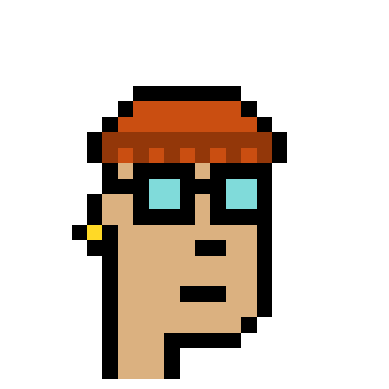

In [12]:
decoded = rand_punk()
print(decoded.shape)

plt.imshow(transforms.functional.to_pil_image(decoded))
plt.axis('off')
plt.show()


Features: female, crazyHair, nerdGlasses, purpleLipstick
Shape: torch.Size([4, 24, 24])


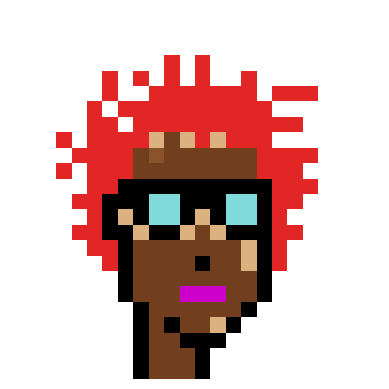

In [13]:
decoded = rand_punk()

plt.imshow(transforms.functional.to_pil_image(decoded))
plt.axis('off')
plt.show()


Features: male, clownHairGreen, bigShades
Shape: torch.Size([4, 24, 24])


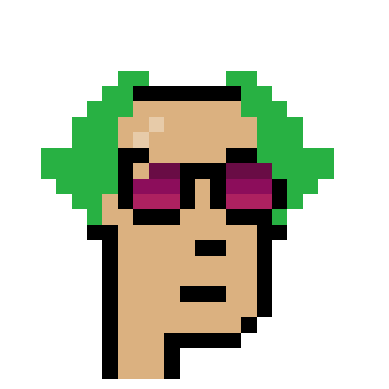

In [14]:
decoded = rand_punk()

plt.imshow(transforms.functional.to_pil_image(decoded))
plt.axis('off')
plt.show()


Features: male, smallShades, stringyHair, earring
Shape: torch.Size([4, 24, 24])


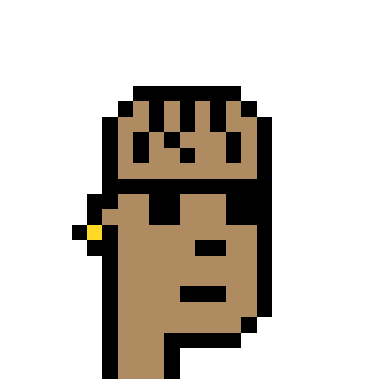

In [15]:
decoded = rand_punk()

plt.imshow(transforms.functional.to_pil_image(decoded))
plt.axis('off')
plt.show()


Features: female, blondeBob, regularShades, hotLipstick
Shape: torch.Size([4, 24, 24])


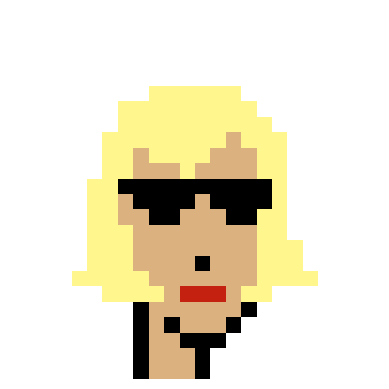

In [16]:
decoded = rand_punk()

plt.imshow(transforms.functional.to_pil_image(decoded))
plt.axis('off')
plt.show()


## Reconstruction

In [17]:
def reconstruct_punk(idx):
    punk = I.get_punk_tensor(idx)
    p = DS.rgba_to_one_hot(punk, dataset.mapper)
    p = p.unsqueeze(0)
    p = p.to(device)

    _, labels = dataset[idx]
    l = labels.unsqueeze(0)
    l = l.to(device)
    enabled_features = [k for k,v in zip(dataset._label_keys, labels) if v.item() == 1]

    model.eval()
    with torch.no_grad():
        reconstructed, mu, logvar = model.forward(p, l)

    recon_punk = reconstructed[0][:222, :, :].cpu()
    recon_punk = DS.one_hot_to_rgba(recon_punk, dataset.mapper)

    return punk, recon_punk, enabled_features


def draw_two(img1, img2):
    page_size = 2
    view_x, view_y = 4*page_size, 2*page_size
    fig = plt.figure(figsize=(view_x, view_y))
    fig.add_subplot(1, 2, 1)
    plt.imshow(transforms.functional.to_pil_image(img1))
    plt.axis('off')
    fig.add_subplot(1, 2, 2)
    plt.imshow(transforms.functional.to_pil_image(img2))
    plt.axis('off')
    plt.show()


### 5 Reconstructions

Features: female, rosyCheeks, darkHair, cigarette


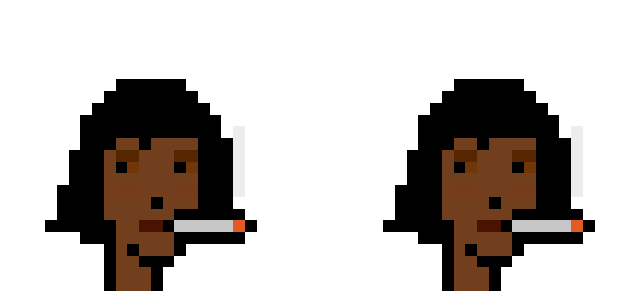

In [18]:
punk, recon_punk, features = reconstruct_punk(1000)

print(f"Features: {', '.join(features)}")
draw_two(punk, recon_punk)

Features: female, stringyHair, purpleLipstick, earring


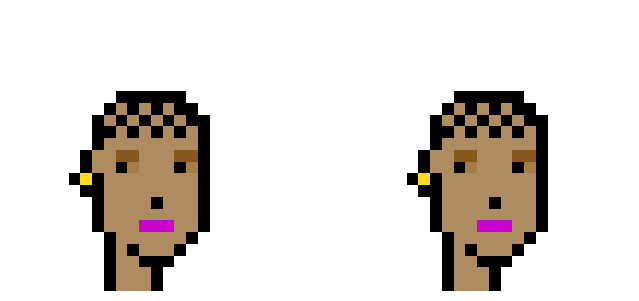

In [19]:
punk, recon_punk, features = reconstruct_punk(2001)

print(f"Features: {', '.join(features)}")
draw_two(punk, recon_punk)


Features: female, wildWhiteHair, greenEyeShadow, hotLipstick


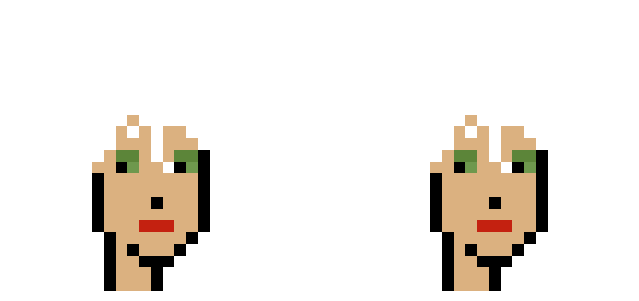

In [20]:
punk, recon_punk, features = reconstruct_punk(5000)

print(f"Features: {', '.join(features)}")
draw_two(punk, recon_punk)

Features: male, rosyCheeks, mustache, vr, cap, cigarette


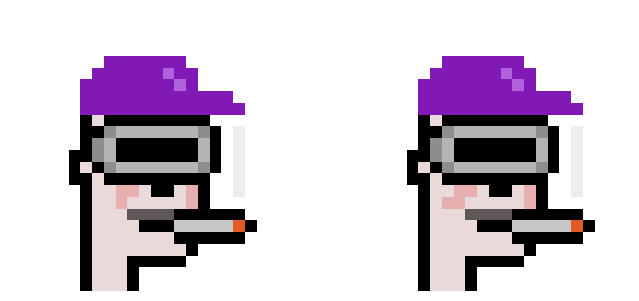

In [21]:
punk, recon_punk, features = reconstruct_punk(8000)

print(f"Features: {', '.join(features)}")
draw_two(punk, recon_punk)

Features: male, handlebars, bandana


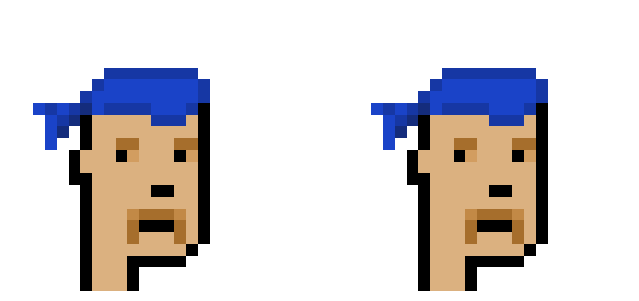

In [22]:
punk, recon_punk, features = reconstruct_punk(1337)

print(f"Features: {', '.join(features)}")
draw_two(punk, recon_punk)

## Losses

<function matplotlib.pyplot.show(close=None, block=None)>

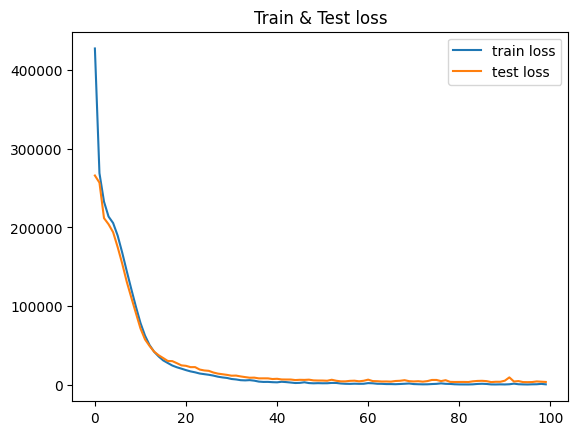

In [23]:
plt.title("Train & Test loss")
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show


In [24]:
train_losses


[427483.40940824465,
 268978.34668661345,
 232732.1991910461,
 213801.30968805408,
 205602.84591090426,
 189604.5780141844,
 167940.38137189715,
 144313.8597351507,
 121501.97314799424,
 99350.58076379655,
 78667.05380097518,
 62522.41008699025,
 50471.031159962324,
 41984.1450333832,
 35945.15501371343,
 30949.717212433512,
 27641.691359499666,
 24434.26324506178,
 22220.65969220966,
 20461.68445257092,
 18599.443118697363,
 16988.39032025709,
 15804.06629456865,
 14299.742919921875,
 13479.228879238697,
 12687.4434572044,
 11647.937193525599,
 10269.37288887619,
 9322.749613876884,
 8665.980938850566,
 7324.560376322861,
 6744.105530218029,
 5807.808379261206,
 5553.931825029089,
 5869.928957891802,
 5185.516676666043,
 4006.05601555574,
 3596.454246575105,
 3653.5364509744845,
 3273.0902831165504,
 3091.1980134138826,
 3795.096735528175,
 3376.629638671875,
 2800.3605190845246,
 2218.1306781092435,
 2396.7558377313276,
 3133.397830827862,
 2144.137175864362,
 1849.681113818013,
 204

In [25]:
test_losses


[266000.7434082031,
 256911.36157226562,
 211849.94982910156,
 204032.0684814453,
 193901.1484375,
 174982.81604003906,
 153961.65112304688,
 130810.28369140625,
 110825.5599975586,
 91147.81927490234,
 71723.9779663086,
 57670.86004638672,
 49347.763732910156,
 42087.58206176758,
 37493.99328613281,
 33938.9992980957,
 30232.28256225586,
 30032.98565673828,
 27405.842765808105,
 24640.750526428223,
 24056.260833740234,
 22388.61962890625,
 22415.072799682617,
 19352.045776367188,
 18192.53960418701,
 17693.5972366333,
 15568.920623779297,
 14176.431686401367,
 13375.86865234375,
 12563.128677368164,
 11527.60888671875,
 11654.338638305664,
 10583.304306030273,
 9727.632308959961,
 8925.653503417969,
 9051.03564453125,
 8113.649326324463,
 8143.696697235107,
 8119.633628845215,
 7284.847261428833,
 7589.599834442139,
 6745.242267608643,
 6655.731439590454,
 6645.869348526001,
 5968.860282897949,
 6283.6253089904785,
 6167.718273162842,
 6476.238988876343,
 5552.370946884155,
 5388.1770